In [2]:
import pandas as pd
import numpy as np
import string
import re
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from tqdm.notebook import tqdm
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')
df = pd.read_csv("/Users/kevinhsu/Downloads/AIT 526/Skynet/data/train.csv", encoding='ISO-8859-1')

In [8]:
df = pd.read_csv("/Users/kevinhsu/Downloads/AIT 526/Skynet/data/IMDB Dataset.csv")

In [9]:
df.dropna(inplace=True)

In [7]:
df_tw = pd.read_csv("/Users/kevinhsu/Downloads/AIT 526/Skynet/data/Twitter Training Data.csv")

In [8]:
df_tw['review']

0        im getting on borderlands and i will murder yo...
1        I am coming to the borders and I will kill you...
2        im getting on borderlands and i will kill you ...
3        im coming on borderlands and i will murder you...
4        im getting on borderlands 2 and i will murder ...
                               ...                        
74677    Just realized that the Windows partition of my...
74678    Just realized that my Mac window partition is ...
74679    Just realized the windows partition of my Mac ...
74680    Just realized between the windows partition of...
74681    Just like the windows partition of my Mac is l...
Name: review, Length: 74682, dtype: object

In [125]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"https?://.+", "", text)
    doc = nlp(text)
    clean_tokens = [
        token.lemma_.lower()
        for token in doc
        if token.text not in string.punctuation  # remove punctuation
        and not token.is_stop                    # remove stopwords
        and token.lemma_ != "-PRON-"             # exclude pronouns
    ]
    return " ".join(clean_tokens)

df['processed_text'] = df['text'].apply(preprocess_text)

In [126]:
y = df['sentiment'].apply(lambda x: 2 if x == 'positive' else 1 if x == 'neutral' else 0)

In [135]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [136]:
models = {
    "XGBoost": XGBClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": SVC(kernel='rbf', C=1, gamma='scale'),
    "Linear SVC": LinearSVC(loss='hinge'),
}

In [ ]:
# Define vectorizers
vectorizers = {
    "Count Vectorizer": CountVectorizer(),
    "TF-IDF": TfidfVectorizer(),
}

# Store results for each combination
all_results = {}

# Test each vectorizer
for vec_name, vectorizer in vectorizers.items():
    # Transform the data
    X = vectorizer.fit_transform(df['processed_text'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Test each model with current vectorizer
    model_results = {}
    for model_name, model in models.items():
        pipeline = Pipeline([
            ('classifier', model)
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        model_results[model_name] = acc
    
    all_results[vec_name] = model_results

# Display results
print("Model performance with different vectorizers:\n")
for vec_name, model_results in all_results.items():
    print(f"\n{vec_name}:")
    print("-" * 40)
    for model_name, acc in model_results.items():
        print(f"{model_name}: {acc:.4f}")

# Find best combination
best_acc = 0
best_vec = ""
best_model = ""

for vec_name, model_results in all_results.items():
    for model_name, acc in model_results.items():
        if acc > best_acc:
            best_acc = acc
            best_vec = vec_name
            best_model = model_name

print(f"\nBest combination:")
print(f"Vectorizer: {best_vec}")
print(f"Model: {best_model}")
print(f"Accuracy: {best_acc:.4f}")

#### Model performance with different vectorizers:

#### **Bag of Words:**
##### ----------------------------------------
##### XGBoost: 0.6960
##### Logistic Regression: 0.6881
##### Naive Bayes: 0.6412
##### Random Forest: 0.6940
##### Gradient Boosting: 0.6499
##### Support Vector Machine: 0.6920
##### K-Nearest Neighbors: 0.5626

#### **TF-IDF:**
##### ----------------------------------------
##### XGBoost: 0.6904
##### Logistic Regression: 0.6800
##### Naive Bayes: 0.6194
##### Random Forest: 0.7003
##### Gradient Boosting: 0.6500
##### Support Vector Machine: 0.6803
##### K-Nearest Neighbors: 0.4514

#### Best combination:
##### Vectorizer: TF-IDF
##### Model: Random Forest
##### Accuracy: 0.7003

In [139]:
from sklearn.metrics import classification_report, confusion_matrix
model = models[best_model]
X = df['processed_text']
y = df['sentiment'].apply(lambda x: 2 if x == 'positive' else 1 if x == 'neutral' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pipeline = Pipeline([
    ('vectorizer', vectorizers[best_vec]),
    ('classifier', model)
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred, labels=[0, 1, 2]))


Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.58      0.65      2356
     neutral       0.66      0.74      0.70      3343
    positive       0.74      0.77      0.76      2545

    accuracy                           0.71      8244
   macro avg       0.72      0.70      0.70      8244
weighted avg       0.71      0.71      0.70      8244


Confusion Matrix:
[[1369  777  210]
 [ 389 2477  477]
 [  85  492 1968]]


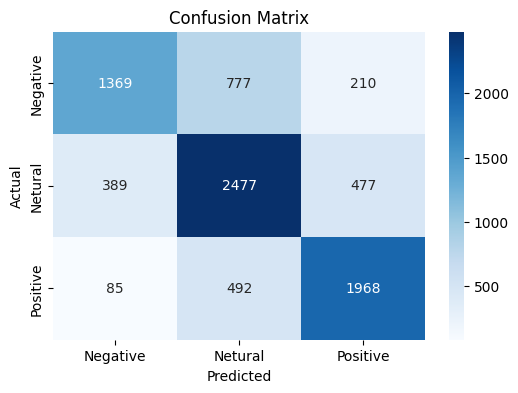

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# y_test = actual labels, y_pred = predicted labels from your model
conf_mat = confusion_matrix(y_test, y_pred)

# Optional: add class names
labels = ['Negative', 'Netural', 'Positive']  # change according to your classes

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### **Random Forest + TF-IDF**

In [122]:
rf_model = RandomForestClassifier()
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df['processed_text'])
y = df['sentiment'].apply(lambda x: 2 if x == 'positive' else 1 if x == 'neutral' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [134]:
probs = rf_model.predict_proba(X_test)

mask = np.any(probs > 0.7, axis=1)
y_test_filtered = y_test[mask]

filtered = probs[mask]
y_predict_filter = np.argmax(filtered, axis=1)

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

conf_mat = confusion_matrix(y_test_filtered, y_predict_filter)

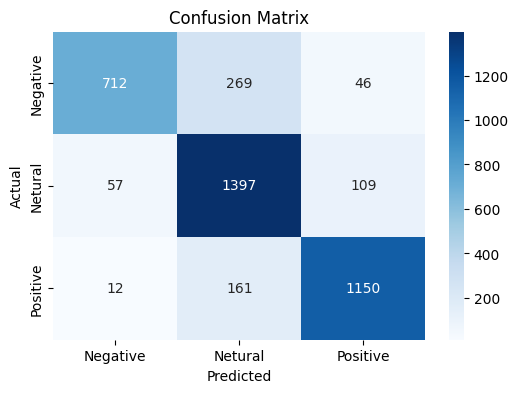

In [136]:
labels = ['Negative', 'Netural', 'Positive']  # change according to your classes

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [130]:
data_cover = y_test_filtered.shape[0]/mask.shape[0]
print("data cover: {:.2f}%".format(data_cover*100))
print("\nClassification Report:")
print(classification_report(y_test_filtered, y_predict_filter, target_names=['negative', 'neutral', 'positive']))

data cover: 47.46%

Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.69      0.79      1027
     neutral       0.76      0.89      0.82      1563
    positive       0.88      0.87      0.88      1323

    accuracy                           0.83      3913
   macro avg       0.85      0.82      0.83      3913
weighted avg       0.84      0.83      0.83      3913



#### **Test Naive Bayes**

In [130]:
df['processed_text']

0                                           i`d respond go
1                                  sooo sad miss san diego
2                                           boss bully ...
3                                          interview leave
4                                 son couldn`t release buy
                               ...                        
27476      wish come u denver   husband lose job can`t ...
27477      i`ve wonder rake   client clear .net don`t f...
27478      yay good enjoy break probably need hectic we...
27479                                              worth  
27480                         flirt go atg smile yay   hug
Name: processed_text, Length: 27481, dtype: object

In [143]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['sentiment'], test_size=0.25, random_state=42)

In [144]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit the vectorizer to the training data and transform the training data
X_train_counts = vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_counts = vectorizer.transform(X_test)

In [145]:
from sklearn.naive_bayes import MultinomialNB

# Create a Multinomial Naive Bayes classifier object
clf = MultinomialNB()

# Train the classifier
clf.fit(X_train_counts, y_train)

MultinomialNB()

In [146]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test data
y_pred = clf.predict(X_test_counts)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Example prediction on a new document
new_document = ["This is a wonderful film, I loved it!"]
new_document_counts = vectorizer.transform(new_document)
predicted_category = clf.predict(new_document_counts)
print("Prediction for '{}': {}".format(new_document[0], predicted_category[0]))

Accuracy: 0.6409547373017028
Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.57      0.62      1957
     neutral       0.58      0.66      0.62      2787
    positive       0.69      0.67      0.68      2127

    accuracy                           0.64      6871
   macro avg       0.65      0.64      0.64      6871
weighted avg       0.65      0.64      0.64      6871

Prediction for 'This is a wonderful film, I loved it!': positive


### **Using Spacy package to encode the text**

In [105]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [103]:
text = "I love this product! It's amazing and works perfectly."

In [108]:
doc = nlp(text)

In [110]:
print(doc._.blob.sentiment_assessments.assessments)

[(['love', '!'], 0.625, 0.6, None), (['amazing'], 0.6000000000000001, 0.9, None), (['perfectly'], 1.0, 1.0, None)]


### **Using Transformer**

In [3]:
import torch
import torch.nn as nn

# Check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# Example input (sequence length = 10, batch size = 32, embedding dim = 512)
src = torch.rand((32, 10, 512)).to(device)  # (batch, seq_len, embed_dim)
tgt = torch.rand((32, 20, 512)).to(device)

transformer = nn.Transformer(d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, batch_first=True).to(device)

output = transformer(src, tgt)
print(output.shape)  # should be (tgt_seq_len, batch_size, d_model)

Using device: mps
torch.Size([32, 20, 512])


In [19]:
text = "I love working with Transformers in NLP"
doc = nlp(text)
tokens = [token.text for token in doc]
vectors = torch.tensor([token.vector for token in doc])  # shape: (seq_len, 300)
vectors = vectors.unsqueeze(0).to(device)  # shape: (1, seq_len, 300)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

transformer = nn.Transformer(d_model=96, nhead=6, num_encoder_layers=3, num_decoder_layers=3, batch_first=True).to(device)

# Dummy target input (e.g., same shape or start token repeated)
tgt = torch.zeros_like(vectors).to(device)

# Run through Transformer
output = transformer(vectors, tgt)  # shape: (batch, seq_len, d_model)
print(output.shape)

Using device: mps
torch.Size([1, 7, 96])


In [34]:
def convert_text_to_transformer_input(text):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    doc = nlp(text)
    vectors = torch.tensor([token.vector for token in doc])  # shape: (seq_len, 300)
    vectors = vectors.unsqueeze(0).to(device)  # shape: (1, seq_len, 300)

    transformer = nn.Transformer(d_model=96, nhead=6, num_encoder_layers=3, num_decoder_layers=3, batch_first=True).to(device)

    # Dummy target input (e.g., same shape or start token repeated)
    tgt = torch.zeros_like(vectors).to(device)

    # Run through Transformer
    output = transformer(vectors, tgt)  # shape: (batch, seq_len, d_model)
    return output

In [ ]:
sentence_embedding = torch.mean(output, dim=1)  # Shape: [1, 96]
sentence_embedding = sentence_embedding.cpu().detach().numpy() 

In [ ]:
# Simulating multiple sentences for illustration
sentences_embeddings = []
y = df['sentiment'].apply(lambda x: 2 if x == 'positive' else 1 if x == 'neutral' else 0)
X = df['processed_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Process each sentence and add to training data
for text in X_train:
    if len(text) == 0:
        continue
    try:
        output = convert_text_to_transformer_input(text)
    except Exception as e:
        print(f"Error processing text: {text}")
        print(e)
        continue
    sent_embedding = torch.mean(output, dim=1).cpu().detach().numpy()
    
    sentences_embeddings.append(sent_embedding)
    

# Convert lists to numpy arrays
X = np.vstack(sentences_embeddings)  # Shape: [n_sentences, 96]
y = np.array(y_train)  # Shape: [n_sentences]

# Train random forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

In [61]:
res_idx = []
item = 0
for text in X_train:
    if len(text) == 0:
        res_idx.append(item)
    item += 1

In [63]:
filtered_list = [item for idx, item in enumerate(X_train) if idx not in res_idx]

In [71]:
X.shape

(19222, 96)

In [75]:
filtered_y = np.delete(y, res_idx, axis=0)

In [ ]:
# Train random forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, filtered_y)

RandomForestClassifier(random_state=42)

In [78]:
test_sentences_embeddings = []
k = 0
record = []
for text in X_test:
    if len(text) == 0:
        record.append(k)
        continue
    try:
        output = convert_text_to_transformer_input(text)
    except Exception as e:
        print(f"Error processing text: {text}")
        print(e)
        record.append(k)
        continue
    sent_embedding = torch.mean(output, dim=1).cpu().detach().numpy()
    
    test_sentences_embeddings.append(sent_embedding)
    k += 1

In [82]:
filtered_y_test = np.delete(y_test, record, axis=0)

In [87]:
X_filter_test = np.vstack(test_sentences_embeddings)

In [88]:
y_pred = rf_model.predict(X_filter_test)

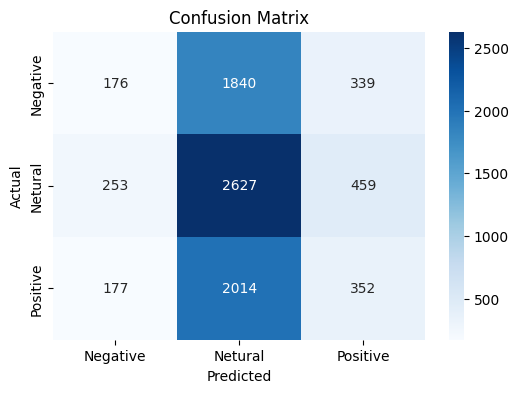

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# y_test = actual labels, y_pred = predicted labels from your model
conf_mat = confusion_matrix(filtered_y_test, y_pred)

# Optional: add class names
labels = ['Negative', 'Netural', 'Positive']  # change according to your classes

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()